# Monte Carlo Simulation of a Game of Trouble

Goal: Test whether or not it is more adventagous to only have one piece on the board at a time or to put one in play every time a six is rolled.
***

Import required modules.

In [1]:
from random import randint
import itertools
import logging
import json

Setup and Init Logging

In [2]:
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
log_file = 'game.log'

# clear log file
try:
    with open(log_file, 'w'):
        pass
except:
    pass

# create file handler
handler = logging.FileHandler(log_file)
handler.setLevel(logging.INFO)

# create a logging format
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# add handlers to the logger
logger.addHandler(handler)

Define the classes for the game.

The lowest, most basic level of the game: the Die

In [3]:
class Dice:
    def __init__(self, sides: int = 6):
        """
        This creates an instance of the dice. Defaults to 6 sides as per the game.
        
        :param sides(int): number of sides of the dice.
        """
        self._sides = sides
        self._roll_again = False
        self._roll_history = []
    
    @property
    def roll_history(self):
        return self._roll_history
    
    @property
    def roll_again(self):
        """
        Return status of roll again.
        
        :return: If max value rolled, this is true, else false.
        :rtype: bool
        """
        return self._roll_again
    
    @roll_again.setter
    def roll_again(self, b):
        """
        Sets the current status of roll_again.
        
        :param b(bool): True | False
        :return: None
        """
        self._roll_again = b
    
    def roll(self):
        """
        Roll the dice. Returns random int between 1 and n sides.
        
        :return: Random dice value
        :rtype: int
        """
        result = randint(1,self._sides)
        self._roll_history.append(result)
        
        if result == self._sides:
            self.roll_again = True
        else:
            self.roll_again = False
        return result
    

Next, the Board, that contains the Die and the spots for the pawns.

In [4]:
class Board:
    def __init__(self, dice:Dice):
        """
        :param dice(Dice): dice object for the board.
        
        note:: Colors in order of the board, using red as start.
        """
        self._locations_size = 0
        self.colors = ['red', 'green', 'yellow', 'blue']
        self.locations = []
        self.locations_dict = {}
        self._build_locations()
        self.dice = dice
        logger.debug('BOARD.INIT: locations_size: {}'.format(self.locations_size))
    
    @property
    def locations_size(self):
        return self._locations_size
    
    @locations_size.setter
    def locations_size(self, n):
        self._locations_size = n
        
    def _build_locations(self):
        for c in self.colors:
            for i in range(1,7):
                loc_id = '{}|{}'.format(c, i)
                self.locations.append(loc_id)
                self.locations_dict[loc_id] = None
        self.locations_size = len(self.locations)
    
    def append_finish_line_locations(self):
        """
        These locations are to be appended AFTER player init. 
        """
        for c in self.colors:
            for i in range(1,5):
                loc_id = '{}|F{}'.format(c,i)
                self.locations.append(loc_id)
                self.locations_dict[loc_id] = None
    
    def pawn_to_location(self, pawn, new_loc_id, current_loc_id = None):
        """
        update pawn locations
        
        todo :: clear previous location
        
        :param pawn(Pawn): pawn object to move
        :param loc_id(str): location id in [color]|[number] format
        """
        
        logger.debug('BOARD.PAWN_TO_LOCATION: NewLoc: {}'.format(self.locations_dict[new_loc_id]))
        # Clear current spot
        if current_loc_id is not None:
            self.locations_dict[current_loc_id] = None
        
        if self.locations_dict[new_loc_id] is None:
            # Spot is open and unoccupied
            self.locations_dict[new_loc_id] = pawn
        else:
            # Spot is occupied. Send other pawn home and occupy.
            self.locations_dict[new_loc_id].send_home()
            self.locations_dict[new_loc_id] = pawn
        

The Pawn comes next.

In [5]:
class Pawn:
    def __init__(self, color, location_order, uid):
        self.color = color
        self._location = 0
        self._active = False
        self._location_order = location_order
        self.uid = uid
        self._on_finish_line = False
        
    def get_location_id(self):
        try:
            if self.location > 0:
                return self._location_order[self.location]
            else:
                return 0
        except:
            # out of bounds
            return None
    
    @property
    def on_finish_line(self):
        return self._on_finish_line
    
    @on_finish_line.setter
    def on_finish_line(self, b: bool):
        self._on_finish_line = b
        
    @property
    def location(self):
        return self._location
    
    @location.setter
    def location(self, loc):
        if loc > 0:
            self.is_active = True
        else:
            self.is_active = False
        self._location = loc
        
    @property
    def is_active(self):
        return self._active
    
    @is_active.setter
    def is_active(self, b: bool):
        self._active = b
        
    def increment_location(self, n):
        """
        Increment location n spaces
        
        :param n(int): increment amount
        """
        x = self.location
        self.location = x + n
        self.is_active = True
        if self.location > 24:
            self.on_finish_line = True
    
    def send_home(self):
        self.location = 0
        self.is_active = False
        

Now the biggest, most complicated class: the Player. This tracks the pawns for the player, contains the rules for the pawn movement, and keeps track of things. One more complicated issue is keeping track of the pawn locations as each player has a different starting and ending points on the board.

In [6]:
class Player:
    def __init__(self, color: str, board: Board, birth_strategy: int = 0,
                select_strategy: int = 0):
        """
        Initialize player.
        
        :param color(str): Color identifier for player.
        :param turn_id(int): Turn sequence for player (1-4)
        :param board(Board): object of the game board
        :param birth_strategy(int): 0 == pull pawn out when 6 rolled; 1 == keep only 1 pawn active.
        :param select_strategy(int): Pawn selection strategy when more than one is active.
                                        0 == random; 1 == least progress; 2 == most progress
        """
        self.color = color
        self.board = board
        self._is_turn = False
        self.location_order = self._build_location_order()
        self._finish_line = {'F1': None, 'F2': None, 'F3': None, 'F4': None}
        self.pawns = []
        self._init_pawns()
        self._birth_strategy = birth_strategy
        self._select_strategy = select_strategy
        self._victory_condition_met = False
    
    def lookup_board_location(self, loc_id: int):
        try:
            return self.location_order[loc_id]
        except:
            return None
    
    @property
    def strategy_select(self):
        return self._select_strategy
    
    @strategy_select.setter
    def strategy_select(self, strategy):
        self._select_strategy = strategy
        
    @property
    def strategy_birth(self):
        return self._birth_strategy
    
    @strategy_birth.setter
    def strategy_birth(self, strategy_id):
        self._birth_strategy = strategy_id
        
    @property
    def victory_condition_met(self):
        return self._victory_condition_met
    
    @victory_condition_met.setter
    def victory_condition_met(self, b:bool):
        self._victory_condition_met = b
    
    @property
    def is_turn(self):
        """
        Check if its players turn
        
        :return: True | False
        :rtype: bool
        """
        return self._is_turn
    
    @is_turn.setter
    def is_turn(self, b):
        """
        Sets the status of is_turn
        
        :param b(bool): True | False
        :return: None
        """
        self._is_turn = b
    
    def _build_location_order(self):
        locs = self.board.locations
        color = self.color
        finish_locs = ['{}|F1'.format(color),'{}|F2'.format(color),'{}|F3'.format(color),'{}|F4'.format(color)]
        color = self.color
        player_start_loc = '{}|4'.format(color)
        
        psl_index = locs.index(player_start_loc)
        locs_a = locs[psl_index:]
        locs_b = locs[:psl_index]
        player_locs = locs_a + locs_b + finish_locs
        return dict(enumerate(player_locs,1))

    def _init_pawns(self):
        uid_prefix = self.color[:1]
        p1 = Pawn(self.color, self.location_order, uid_prefix+'1')
        p2 = Pawn(self.color, self.location_order, uid_prefix+'2')
        p3 = Pawn(self.color, self.location_order, uid_prefix+'3')
        p4 = Pawn(self.color, self.location_order, uid_prefix+'4')
        self.pawns = [p1,p2,p3,p4]
        
    def get_pawn_board_locations(self):
        """
        note:: deprecated?
        todo:: implement finish line
        """
        board_locs = []
        for p in self.pawns:
            ploc = p.location
            if ploc == 0:
                loc = 'home'
            elif 0 < ploc <= 28:
                loc = self.location_order[ploc]
            else:
                loc = None
            board_locs.append(loc)
        return board_locs
    
    def _get_active_pawns(self):
        active = []
        for p in self.pawns:
            if p.is_active:
                active.append(p)
        return active
    
    def _get_pawn_least_progress(self, active_pawns):
        least_pawn = None
        for p in active_pawns:
            if least_pawn == None:
                least_pawn = p
            else:
                if p.location < least_pawn.location:
                    least_pawn = p
        return least_pawn
        
    def _get_pawn_most_progress(self, active_pawns):
        most_pawn = None
        for p in active_pawns:
            if most_pawn == None:
                most_pawn = p
            else:
                if p.location > most_pawn.location:
                    most_pawn = p
        return most_pawn
    
    def _get_pawn_at_home(self):
        """
        If there is a pawn at home, select, otherwise return None.
        """
        for p in self.pawns:
            if p.location == 0:
                return p
        return None
    
    def _select_active_pawn(self, active_pawns):
        strategy = self.strategy_select
        
        if len(active_pawns) == 1:
            logger.debug('PLAYER._SELECT_ACTIVE_PAWN: One')
            return active_pawns[0]
        elif len(active_pawns) == 0:
            logger.debug('PLAYER._SELECT_ACTIVE_PAWN: None')
            # No active pawn. All should be home in this condition
            return None
        elif len(active_pawns) > 1:
            logger.debug('PLAYER._SELECT_ACTIVE_PAWN: Multiple')
            if strategy == 0:
                # select random
                i = randint(0, len(active_pawns)-1)
                pawn = active_pawns[i]
            elif strategy == 1:
                # least progress
                pawn = self._get_pawn_least_progress(active_pawns)
            elif strategy == 2:
                # least progress
                pawn = self._get_pawn_most_progress(active_pawns)
            
            if pawn is not None:
                logger.debug('SELECT_ACTIVE_PAWN: {} Selected at location {}'.format(pawn.uid, pawn.get_location_id()))
                return pawn
            else:
                logger.debug('WTF: player._select_active_pawn')
    
    def _select_home_pawn(self, active_pawns):
        home_pawn = self._get_pawn_at_home()
        if home_pawn is not None:
            return home_pawn
        else:
            # select active pawn if home is empty
            return self._select_active_pawn(active_pawns)
    
    def _get_movable_pawns(self, roll):
        """
        Get a list of movable pawns that would be in bounds and not displacing the same color
        
        :param roll(int): roll value to check spot the pawn would be moving to
        
        :rtype: list
        
        """
        logger.debug('-'*20)
        logger.debug('PLAYER._GET_MOVABLE_PAWNS >>')
        active_pawns = self._get_active_pawns()
        movable_pawns = []
        for pawn in active_pawns:
            new_loc = pawn.location + roll
            new_loc_board_id = self.lookup_board_location(new_loc)
            board_loc = self.lookup_board_location(pawn.location)
             
            logger.debug('>> NewLoc: {} | NewLocId: {}'.format(new_loc, new_loc_board_id))
            if new_loc_board_id is not None:
                # in bounds
                new_board_loc = self.board.locations_dict[new_loc_board_id]
                logger.debug('>> board_loc: {}'.format(board_loc))
                if new_board_loc is not None:
                    if new_board_loc.color == self.color:
                        # Can't displace own color
                        logger.debug('>> Occupied by same color')
                        pass
                    else:
                        # Occupied by other color, can send home
                        movable_pawns.append(pawn)
                else:
                    # Spot is empty and available
                    logger.debug('>> Spot Open')
                    movable_pawns.append(pawn)
        logger.debug('>> Movable Pawn Count: {}'.format(len(movable_pawns)))
        logger.debug('_'*20)
        return movable_pawns
    
    def _select_pawn(self, roll):
        birth_strategy = self.strategy_birth
        #active_pawns = self._get_active_pawns()
        movable_pawns = self._get_movable_pawns(roll) 
        
        if roll == self.board.dice._sides:
            # if a 6 is rolled on 6 sided die
            if birth_strategy == 0:
                # Activate a pawn in home if spot 1 is open
                init_loc = self.location_order[1]
                new_born_pawn = self.board.locations_dict[init_loc]
                if new_born_pawn is None:
                    return self._select_home_pawn(movable_pawns)
                else:
                    return new_born_pawn
                
            elif birth_strategy == 1:
                # keep only 1 active
                if len(movable_pawns) > 0:
                    return self._select_active_pawn(movable_pawns)
                else:
                    return self._select_home_pawn(movable_pawns)
                
        else:
            # anything but say a 6 is rolled
            if len(movable_pawns) > 0:
                # there are active pawns
                pawn = self._select_active_pawn(movable_pawns)
                #logger.debug('PLAYER._SELECT_PAWN: Pawn Selected: {}'.format(pawn.uid))
                return pawn
            else:
                logger.debug('PLAYER._SELECT_PAWN: Selected NONE | Movable Count: {}'.format(len(movable_pawns)))
                return None
    
    def move_pawn(self, pawn, n_spots):
        """

        """
        current_loc_id = pawn.location
        current_board_loc_id = pawn.get_location_id()
        logger.debug('PLAYER.MOVE_PAWN: pawn.location: {}'.format(current_loc_id))
        
        if current_loc_id == 0 and n_spots == self.board.dice._sides:
            # in home
            new_loc_id = current_loc_id + 1
            board_loc = self.location_order[new_loc_id]
            pawn.increment_location(1)
            new_board_loc_id = self.location_order[new_loc_id]
            self.board.pawn_to_location(pawn, new_board_loc_id)
            logger.debug('PLAYER.MOVE_PAWN[BIRTH]: New Board Location: {}'.format(board_loc))
        else:
            new_loc_id = current_loc_id + n_spots
            if (current_loc_id + n_spots) <= self.board.locations_size:
                new_board_loc_id = self.location_order[new_loc_id]
                # active and not going to finish line
                logger.debug('PLAYER.MOVE_PAWN[NORMAL]: From [{}] To [{}]'.format(current_board_loc_id, new_board_loc_id))
                # update pawn itself
                pawn.increment_location(n_spots)
                # update board locations
                self.board.pawn_to_location(pawn, new_board_loc_id, current_board_loc_id)

            elif (current_loc_id + n_spots) <= (self.board.locations_size + 4):
                new_board_loc_id = self.location_order[new_loc_id]
                # can go to finish line
                logger.debug('PLAYER.MOVE_PAWN[FINISH LINE]: From [{}] To [{}]'.format(current_board_loc_id, new_board_loc_id))
                # update pawn itself
                pawn.increment_location(n_spots)
                # update board locations
                self.board.pawn_to_location(pawn, new_board_loc_id, current_board_loc_id)
            else:
                # cant move
                logger.debug('PLAYER.MOVE_PAWN: CANT MOVE | current: {} new: {} n_spots: {}'.format(current_loc_id, new_loc_id, n_spots))
                pass
    
    def check_victory_condition_met(self):
        n_on_finish_line = 0
        for p in self.pawns:
            if p.on_finish_line:
                n_on_finish_line += 1
        
        if n_on_finish_line == 4:
            return True
        else:
            return False
        
    def take_turn(self):
        dice = self.board.dice
        self.is_turn = True
        while self.is_turn == True and self.victory_condition_met == False:
            # roll dice
            roll = dice.roll()
            logger.debug('PLAYER.TAKE_TURN: Player {} rolls {}'.format(self.color, roll))
            # select pawn
            pawn_to_move = self._select_pawn(roll)
            
            # do moves
            if pawn_to_move is not None:
                logger.debug('PLAYER.TAKE_TURN.MOVE: SELECTED PAWN UID: {}'.format(pawn_to_move.uid))
                self.move_pawn(pawn_to_move, roll)
            
            # Dice object handles roll again logic
            if not dice.roll_again:
                self.is_turn = False
            
            self.victory_condition_met = self.check_victory_condition_met()
            

The Game class is the top level class for the game (obviously). It has, players, a board, and a dice. 

In [7]:
class Game:
    def __init__(self, player_count: int, turn_limit=1000, allow_random_select:bool = False):
        self.dice = Dice()
        self.board = Board(self.dice)
        self._pawn_select_option_min = None
        self._allow_random_select = None
        self.allow_random_select = allow_random_select
        self._players = [] # unordered
        self.players = {} # ordered
        self.init_players(player_count)
        self.failsafe_turn_limit = turn_limit
        self._end_game = False
        self.results = {'turn_limit':turn_limit
                        ,'turns_taken': 0
                        ,'end_type': 'draw'
                        ,'winner_birth_strategy': None
                        ,'winner_select_strategy': None
                        ,'player_count': player_count}
    
    @property
    def allow_random_select(self):
        return self._allow_random_select
    
    @allow_random_select.setter
    def allow_random_select(self, b):
        if b:
            self._pawn_select_option_min = 0
        else:
            self._pawn_select_option_min = 1
            
        self._allow_random_select = b
    
    @property
    def end_game(self):
        return self._end_game
    
    @end_game.setter
    def end_game(self, b: bool):
        self._end_game = b
    
    def _pick_random_color(self, colors):
        random = randint(1, len(colors)) - 1
        return colors[random]
    
    def init_players(self, player_count):
        colors_avail = self.board.colors.copy()
        color_order = enumerate(colors_avail.copy())
        
        # randomly create player assignments
        for i in range(player_count):
            random_color = self._pick_random_color(colors_avail)
            colors_avail.remove(random_color)
            new_player = Player(color=random_color, board=self.board, birth_strategy=randint(0,1),
                               select_strategy=randint(self._pawn_select_option_min,2))
            self._players.append(new_player)
        
        # order players by color so play order isnt random
        n = 0
        for c in color_order:
            for p in self._players:
                if p.color == c[1]:
                    self.players[n] = p
                    n += 1
        
        logger.debug('Game Initialized with {} players'.format(player_count))
        self.board.append_finish_line_locations()
        
    def play(self):
        player_ids = list(self.players.keys())
        
        turn_id = 0
        for pid in itertools.cycle(player_ids):
            # prevent infinite loop
            if turn_id < self.failsafe_turn_limit and self.end_game == False:
                player = self.players[pid]
                player.take_turn()
                if player.victory_condition_met:
                    # player has won, end game
                    logger.debug('*'*50)
                    logger.debug('*** PLAYER {} HAS WON ***'.format(str.upper(player.color)))
                    logger.debug('*'*50)
                    self.end_game = True
                    # update results dict if won
                    if self.end_game:
                        self.results['turns_taken'] = turn_id
                        self.results['end_type'] = 'victory'
                        self.results['winner_birth_strategy'] = player.strategy_birth
                        self.results['winner_select_strategy'] = player.strategy_select
                                            
            else:
                self.results['turns_taken'] = turn_id
                break
            
            turn_id += 1
            
        
            
        

The Simulation class is what initializes games, runs them, and ultimately keeps track of the results. At the end of the simulation, it dumps the results to a JSON file for later analysis (either further down, or externally).

In [8]:
class Simulation:
    def __init__(self, n_sims: int = 10, n_players: int = 0, turn_limit: int = 1000, 
                 result_file:str = 'SimulationResults.json', allow_random_select:bool = False):
        """
        :param n_players(int): number of players. 0 == Random
        :param n_sims(int): number of simulated games to run.
        :param turn_limit(int): number of turns allowed. Prevents endless looping.
        :param result_file(str): file name to dump json results to. make sure ends with .json
        :param allow_random_select(bool): If False, pawn select strategy of 'Random' will be disabled
        
        note:: birth_strategy(int): 0 == pull pawn out when 6 rolled; 1 == keep only 1 pawn active.
        note:: select_strategy(int): Pawn selection strategy when more than one is active.
                                        0 == random; 1 == least progress; 2 == most progress
        """
        
        self._n_players = n_players
        self._n_sims = n_sims
        self._turn_limit = turn_limit
        self._allow_random_select = allow_random_select
        self.n_sims = n_sims
        self.n_players = n_players
        
        if n_players == 0:
            self._n_players_random = True
        else:
            self._n_players_random = False
        
        self.turn_limit = turn_limit
        self.results = []
        self.result_file = './' + result_file
        self._strategy_defs = {'birth_strategy':{0:'Pull Out Pawn on Every 6'
                                                ,1:'Keep Only One Pawn Active'}
                              ,'select_strategy':{0:'Random'
                                                 ,1:'Least Progress'
                                                 ,2:'Most Progress'}
                              }
    @property
    def allow_random_select(self):
        return self._allow_random_select
    
    @allow_random_select.setter
    def allow_random_select(self, b):
        self._allow_random_select = b
    
    @property
    def turn_limit(self):
        return self._turn_limit
    
    @turn_limit.setter
    def turn_limit(self, n):
        if n < 10:
            self._turn_limit = 10
        elif n > 1000000:
            self._turn_limit = 1000000
    
    @property
    def n_sims(self):
        return self._n_sims
    
    @n_sims.setter
    def n_sims(self, n: int):
        if n < 1:
            self._n_sims = 10
        else:
            self._n_sims = n
    
    @property
    def n_players(self):
        return self._n_players
    
    @n_players.setter
    def n_players(self, n: int):
        if n == 0:
            self._n_players = randint(2,4)
        elif 2 > n > 4:
            self._n_players = randint(2,4)
        else:
            self._n_players = n_players
            
    def run(self):
        logger.info('Starting Simulation of {} trials.'.format(self.n_sims))
        for i in range(self.n_sims):
            if self._n_players_random:
                self.n_players = 0 # inits random
            
            logger.debug('='*50)
            logger.debug('--- GAME {} BEGIN ---'.format(i))
            logger.debug('='*50)
            game = Game(self.n_players, turn_limit=self.turn_limit, allow_random_select=self.allow_random_select)
            game.play()
            self.results.append(game.results)
            logger.debug('='*50)
            logger.debug('--- GAME {} END ---'.format(i))
            logger.debug('='*50)
        logger.info('Simulations completed.') 
    def export_results_json(self):
        logger.info('DUMPING RESULTS TO JSON...')
        data = {'meta':{'sim_count':self.n_sims}
                ,'strategy_key': self._strategy_defs
                ,'results':self.results}
        with open(self.result_file, 'w') as rf:
            json.dump(data, rf)
        logger.info('DUMP COMPLETE.')
        

--- 
Code Below Runs Simulation.
If you have already ran it and want to do the interpretation further down on previous results, just set RUN to False. This is handy when tweaking the graphing outputs so you arent waiting on a simulation to run each time you want to test.
***

In [9]:
RUN = False #  False uses data from previous dump for interpretation if available.
if RUN:
    simulation = Simulation(n_sims=100000, allow_random_select=True)
    simulation.run()
    simulation.export_results_json()
    print('COMPLETE')

COMPLETE


---
# Interpret Results

Import JSON dump file of results from the previous simulation

In [10]:
# Load data
%matplotlib inline
import pandas as pd

json_data_loc = 'SimulationResults.json'
json_file = open(json_data_loc)
json_str = json_file.read()
json_data = json.loads(json_str)

Load the JSON data to dictionaries

In [11]:
data = json_data['results']
strat_key = json_data['strategy_key']

Load the result data to a pandas dataframe and get stats.

In [12]:
df = pd.DataFrame(data)
df.describe()

player_count  turn_limit    turns_taken  winner_birth_strategy  \
count  100000.000000    100000.0  100000.000000           99959.000000   
mean        3.003670      1000.0     138.815760               0.531148   
std         0.818195         0.0      59.397663               0.499031   
min         2.000000      1000.0      35.000000               0.000000   
25%         2.000000      1000.0      93.000000               0.000000   
50%         3.000000      1000.0     129.000000               1.000000   
75%         4.000000      1000.0     173.000000               1.000000   
max         4.000000      1000.0    1000.000000               1.000000   

       winner_select_strategy  
count            99959.000000  
mean                 1.023310  
std                  0.831726  
min                  0.000000  
25%                  0.000000  
50%                  1.000000  
75%                  2.000000  
max                  2.000000

In [13]:
birth_key = strat_key['birth_strategy']
birth_key = {int(k):v for k,v in birth_key.items()}
df['BirthStrategy'] = df['winner_birth_strategy'].map(birth_key)

In [14]:
select_key = strat_key['select_strategy']
select_key = {int(k):v for k,v in select_key.items()}
df['SelectStrategy'] = df['winner_select_strategy'].map(select_key)

In [15]:
df.BirthStrategy.describe()

count                         99959
unique                            2
top       Keep Only One Pawn Active
freq                          53093
Name: BirthStrategy, dtype: object

In [16]:
df.SelectStrategy.describe()

count             99959
unique                3
top       Most Progress
freq              35766
Name: SelectStrategy, dtype: object

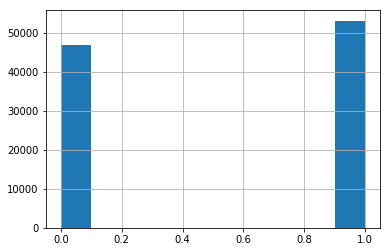

In [17]:
df.winner_birth_strategy.hist()

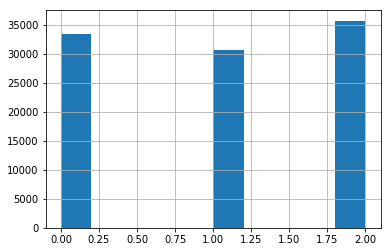

In [18]:
df.winner_select_strategy.hist()

In [19]:
#df.to_excel('MonteCarloResults.xlsx')

# Better Graphing of Results
The above graphs give some quick insight, but aren't the easiest to read. Borrowing from the Matplotlib examples, we take it up a notch or two in readability.

In [20]:
#%matplotlib notebook
import matplotlib.pyplot as plt

# grab data from above
dfg = df[['BirthStrategy','SelectStrategy']].reset_index().copy()  # dfg is just dataframe graph and quick to type

# agg data
agg = dfg.groupby(['BirthStrategy','SelectStrategy']).agg({'index':'count'}).rename(columns={'index':'count'})

In [21]:
agg.unstack()

count                     
SelectStrategy            Least Progress Most Progress Random
BirthStrategy                                                
Keep Only One Pawn Active          17172         18089  17832
Pull Out Pawn on Every 6           13585         17677  15604

In [22]:
import numpy as np
import matplotlib

In [23]:
results = np.array(agg.unstack().values)
l_birth_strat = agg.unstack().index.values
l_select_strat = [x[1] for x in list(agg.unstack())]

Graphing stuff shamelessly pulled from: https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

In [24]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on bottom.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw, fontsize='xx-large',weight='bold')
            texts.append(text)

    return texts

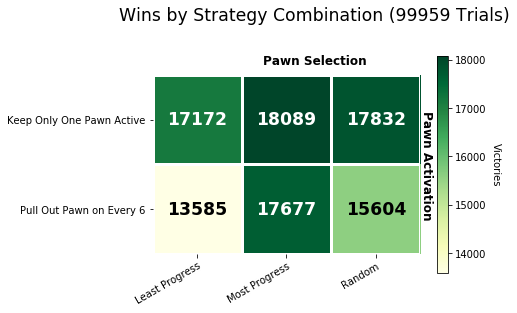

In [25]:
fig, ax = plt.subplots()


im, cbar = heatmap(results, l_birth_strat, l_select_strat, ax=ax,
                   cmap="YlGn", cbarlabel="Victories")
texts = annotate_heatmap(im, valfmt="{x:.0f}")
plt.suptitle('Wins by Strategy Combination ({} Trials)'.format(np.sum(results)), x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.85, 'Pawn Selection', ha='center', fontsize='large', weight='bold')
fig.text(0.745, 0.5, 'Pawn Activation', va='center', rotation=-90, fontsize='large', weight='bold')
fig.patch.set_facecolor('white')
plt.show()



In [26]:
one_pawn_success_rate = sum(results[0]) / np.sum(results)
print('One Active Pawn Success Rate: {:.1f}%'.format(one_pawn_success_rate*100))

One Active Pawn Success Rate: 53.1%
